# Import Data and Libraries

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import os
!pip install tensorflow
!pip install git+https://github.com/openai/CLIP.git
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, layers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision
from sklearn.metrics import classification_report
from google.colab import drive
from IPython.display import Javascript
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
import clip
import torch
from PIL import Image
from torchvision import datasets
from torch.utils.data import DataLoader

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-tmoiyz_f
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-tmoiyz_f
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.3 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=4d56edc5b9d4baeb47c459f3a0de400e67bcebfed78c99ca9f2edbcc95044759
  Stored in directory: /tmp/pip-ephem-wheel-cache-50jkt8od/wheels/3f/7c/a4/9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = '/content/drive/MyDrive/dataset_split/train'
test_path = '/content/drive/MyDrive/dataset_split/test'

In [139]:
train_dataset = image_dataset_from_directory(
    train_path,
    image_size=(224, 224),
    validation_split=.2,
    subset='training',
    batch_size = 32,
    seed=123)

validation_dataset = image_dataset_from_directory(
    train_path,
    image_size=(224, 224),
    validation_split=.2,
    subset='validation',
    batch_size = 32,
    seed=123)

test_dataset = image_dataset_from_directory(
    test_path,
    image_size=(224, 224),
    batch_size = 32)

train_overfit_dataset = image_dataset_from_directory(
    train_path,
    image_size=(224, 224),
    batch_size = 32)

class_names = train_dataset.class_names
test_class_names = test_dataset.class_names
train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)
train_overfit_dataset = train_overfit_dataset.shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)

Found 4986 files belonging to 3 classes.
Using 3989 files for training.
Found 4986 files belonging to 3 classes.
Using 997 files for validation.
Found 1245 files belonging to 3 classes.
Found 4986 files belonging to 3 classes.


In [140]:
print(class_names)
print(test_class_names)

['burger', 'hotdog', 'pizza']
['burger', 'hotdog', 'pizza']


# Step 1: Initial Model Creation

In [144]:
def define_model(filter_list, dataset_train, dataset_val,
                 callback_loss = 'val_loss', batch = False, dropout = False,
                 augmentation = 0,
                 l2 = False, pooling_interval = 1, patience = 5):
    inputs = keras.Input(shape=(224, 224, 3))
    x = layers.Rescaling(1./255)(inputs)
    if augmentation == 1:
        x = layers.RandomWidth(0.1)(x, training=True)
        x = layers.RandomHeight(0.1)(x, training=True)
    elif augmentation == 2:
        x = layers.RandomFlip("horizontal_and_vertical")(x, training=True)
        x = layers.RandomRotation(0.1)(x, training=True)
        x = layers.RandomWidth(0.1)(x, training=True)
        x = layers.RandomHeight(0.1)(x, training=True)
    elif augmentation == 3:
        x = layers.RandomFlip("horizontal_and_vertical")(x, training=True)
        x = layers.RandomRotation(0.1)(x, training=True)
        x = layers.RandomWidth(0.1)(x, training=True)
        x = layers.RandomHeight(0.1)(x, training=True)
        x = layers.RandomZoom(0.1)(x, training=True)
        x = layers.RandomContrast(0.1)(x, training=True)

    iterations = 1
    for filters in filter_list:
        if(l2):
            x = layers.Conv2D(filters=filters, kernel_size=3, padding='valid', kernel_regularizer=regularizers.l2(0.01))(x)
        else:
          x = layers.Conv2D(filters=filters, kernel_size=3, padding='valid')(x)
        if(batch):
            x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        if(iterations % pooling_interval == 0):
            x = layers.MaxPooling2D(pool_size=2)(x)
        iterations += 1
    x = layers.GlobalAveragePooling2D()(x)
    if(l2):
      x = layers.Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    else:
      x = layers.Dense(10, activation='relu')(x)
    if(dropout):
        x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(3, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.summary()
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath='hotdog_convnet.keras.weights.h5',
            save_weights_only=True,
            monitor=callback_loss,
            save_best_only=True
        ),
        keras.callbacks.EarlyStopping(monitor=callback_loss, patience=patience)
    ]
    history = model.fit(
        dataset_train,
        epochs=100,
        validation_data=dataset_val,
        callbacks=callbacks)
    return model, history

def plot(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

def metrics(model, test_dataset):
    y_true = []
    y_pred = []

    for x_batch, y_batch in test_dataset:
        preds = model.predict(x_batch, verbose=0)
        y_true.extend(y_batch)
        y_pred.extend(np.argmax(preds, axis=1))

    # Safe loss/accuracy call
    loss, acc = model.evaluate(test_dataset, verbose=0)
    print(f"\nTest Loss: {loss:.4f}")
    print(f"Test Accuracy: {acc:.4f}")

    print(f"\n--- Classification Report ---")
    print(classification_report(y_true, y_pred, digits=4, target_names=class_names))


def beep():
  display(Javascript('new Audio("https://actions.google.com/sounds/v1/alarms/beep_short.ogg").play()'))

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_29 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 222, 222, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_95 (MaxPooling2D) │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_96 (Conv2D)              │ (None, 109, 109, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_96 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_97 (Conv2D)              │ (None, 52, 52, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 52, 52, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_97 (MaxPooling2D) │ (None, 26, 26, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 10)             │       108,170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,083 (519.86 KB)

 Trainable params: 133,083 (519.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.4790 - loss: 1.0331 - val_accuracy: 0.5036 - val_loss: 0.9785
Epoch 2/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.5537 - loss: 0.9305 - val_accuracy: 0.5928 - val_loss: 0.8727
Epoch 3/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.5944 - loss: 0.8656 - val_accuracy: 0.6040 - val_loss: 0.8378
Epoch 4/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - accuracy: 0.6316 - loss: 0.7935 - val_accuracy: 0.5944 - val_loss: 0.8535
Epoch 5/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - accuracy: 0.6556 - loss: 0.7572 - val_accuracy: 0.6586 - val_loss: 0.7908
Epoch 6/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.6750 - loss: 0.7265 - val_accuracy: 0.6803 - val_loss: 0.7624
Epoch 7/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.7271 - loss: 0.6555 - val_accuracy: 0.6442 - val_loss: 0.8709
Epoch 8/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 16s 78ms/step - accuracy: 0.7398 - loss: 0

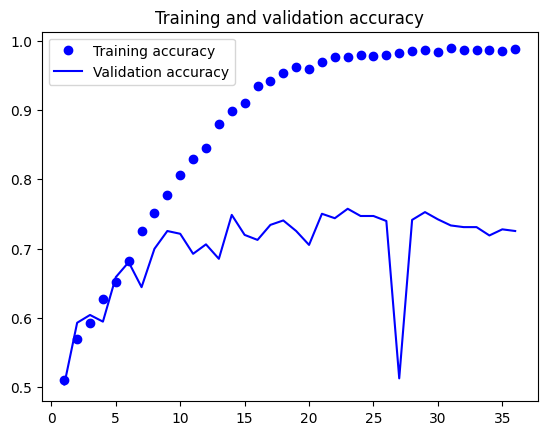

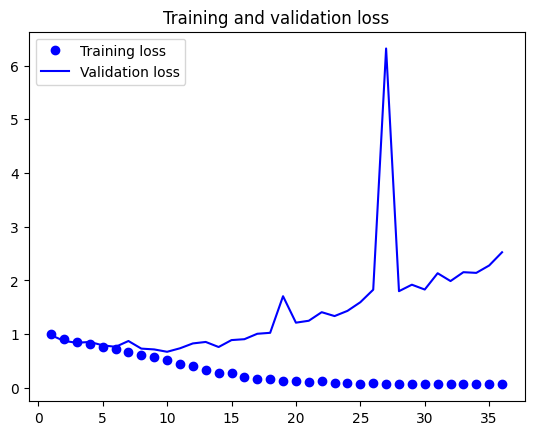


--- Classification Report for model ---
              precision    recall  f1-score   support

      burger     0.5951    0.5788    0.5868       292
      hotdog     0.8140    0.6374    0.7149       364
       pizza     0.7426    0.8523    0.7937       589

    accuracy                         0.7253      1245
   macro avg     0.7172    0.6895    0.6985      1245
weighted avg     0.7289    0.7253    0.7221      1245



<IPython.core.display.Javascript object>

In [ ]:
# Train the model
filter_list = [64, 32, 16]
model, history = define_model(filter_list = filter_list, dataset_train=train_overfit_dataset, dataset_val=test_dataset, callback_loss='accuracy')

# Plot training history
plot(history)

#Do metrics
metrics(model, test_dataset)

#So I know it's done
beep()

Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_30 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_98 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_98 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_99 (Conv2D)              │ (None, 109, 109, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 109, 109, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_99 (MaxPooling2D) │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_100 (Conv2D)             │ (None, 52, 52, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 52, 52, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_100               │ (None, 26, 26, 8)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_30 (Flatten)            │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 10)             │        54,090 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,803 (237.51 KB)

 Trainable params: 60,803 (237.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4753 - loss: 1.0302 - val_accuracy: 0.5205 - val_loss: 0.9796
Epoch 2/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.5655 - loss: 0.9202 - val_accuracy: 0.6273 - val_loss: 0.8362
Epoch 3/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.6258 - loss: 0.8322 - val_accuracy: 0.4964 - val_loss: 1.0110
Epoch 4/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.6788 - loss: 0.7540 - val_accuracy: 0.6386 - val_loss: 0.8034
Epoch 5/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.7047 - loss: 0.6995 - val_accuracy: 0.5936 - val_loss: 0.9031
Epoch 6/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.7352 - loss: 0.6435 - val_accuracy: 0.6610 - val_loss: 0.7909
Epoch 7/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.7644 - loss: 0.5738 - val_accuracy: 0.6490 - val_loss: 0.8918
Epoch 8/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.7823 - loss: 0.5

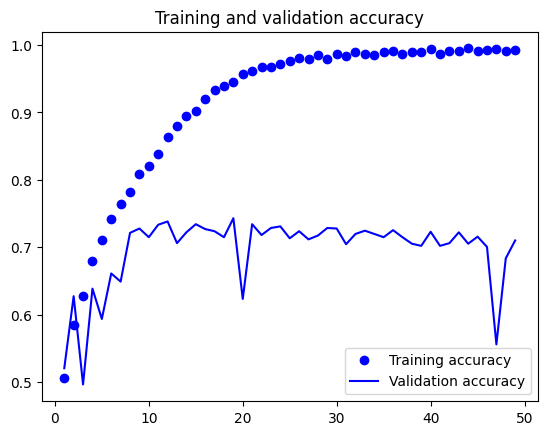

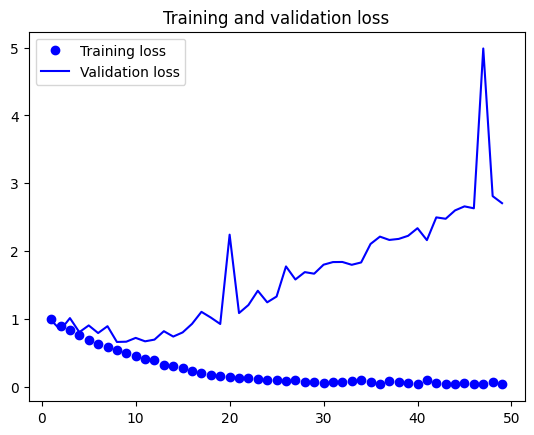


--- Classification Report for model ---
              precision    recall  f1-score   support

      burger     0.5477    0.6096    0.5770       292
      hotdog     0.7315    0.6511    0.6890       364
       pizza     0.7869    0.7963    0.7916       589

    accuracy                         0.7100      1245
   macro avg     0.6887    0.6857    0.6858      1245
weighted avg     0.7146    0.7100    0.7112      1245



<IPython.core.display.Javascript object>

In [ ]:
# Train the model
filter_list = [32, 16, 8]
model, history = define_model(filter_list = filter_list, dataset_train=train_overfit_dataset, dataset_val=test_dataset, callback_loss='accuracy')

# Plot training history
plot(history)

#Do metrics
metrics(model, test_dataset)

#So I know it's done
beep()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_31 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 222, 222, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_101               │ (None, 111, 111, 16)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_102 (Conv2D)             │ (None, 109, 109, 6)    │           870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 109, 109, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_102               │ (None, 54, 54, 6)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 52, 52, 4)      │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 52, 52, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_103               │ (None, 26, 26, 4)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_31 (Flatten)            │ (None, 2704)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 10)             │        27,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,621 (111.80 KB)

 Trainable params: 28,621 (111.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.4482 - loss: 1.0588 - val_accuracy: 0.5221 - val_loss: 1.0145
Epoch 2/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5226 - loss: 0.9597 - val_accuracy: 0.5478 - val_loss: 0.9339
Epoch 3/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.6046 - loss: 0.8749 - val_accuracy: 0.5743 - val_loss: 0.9509
Epoch 4/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.6267 - loss: 0.8328 - val_accuracy: 0.6104 - val_loss: 0.8378
Epoch 5/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.6713 - loss: 0.7821 - val_accuracy: 0.6056 - val_loss: 0.8650
Epoch 6/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6816 - loss: 0.7275 - val_accuracy: 0.6185 - val_loss: 0.8238
Epoch 7/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.7065 - loss: 0.6916 - val_accuracy: 0.6353 - val_loss: 0.8264
Epoch 8/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.7320 - loss: 0.6565 - 

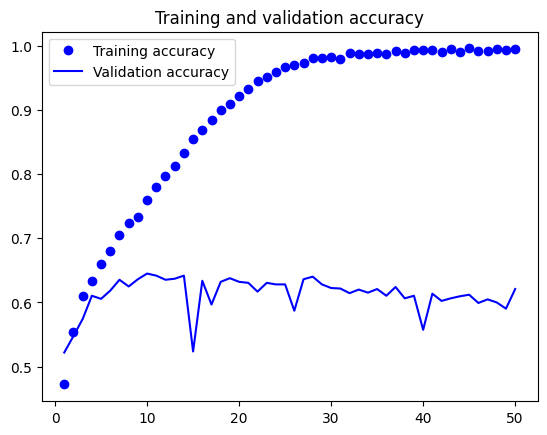

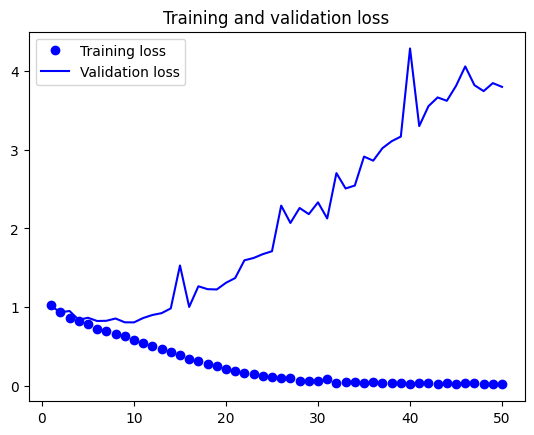


--- Classification Report for model ---
              precision    recall  f1-score   support

      burger     0.4921    0.4247    0.4559       292
      hotdog     0.5691    0.4753    0.5180       364
       pizza     0.6909    0.8081    0.7449       589

    accuracy                         0.6209      1245
   macro avg     0.5840    0.5694    0.5729      1245
weighted avg     0.6086    0.6209    0.6108      1245



<IPython.core.display.Javascript object>

In [ ]:
# Train the model
filter_list = [16, 6, 4]
model, history = define_model(filter_list = filter_list, dataset_train=train_overfit_dataset, dataset_val=test_dataset, callback_loss='accuracy')

# Plot training history
plot(history)

#Do metrics
metrics(model, test_dataset)

#So I know it's done
beep()

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_32 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_32 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 222, 222, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 222, 222, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_104               │ (None, 111, 111, 8)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (None, 109, 109, 3)    │           219 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 109, 109, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_105               │ (None, 54, 54, 3)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (None, 52, 52, 2)      │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 52, 52, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_106               │ (None, 26, 26, 2)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_32 (Flatten)            │ (None, 1352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 10)             │        13,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,062 (54.93 KB)

 Trainable params: 14,062 (54.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4753 - loss: 1.0331 - val_accuracy: 0.5004 - val_loss: 0.9735
Epoch 2/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5227 - loss: 0.9698 - val_accuracy: 0.5349 - val_loss: 0.9528
Epoch 3/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5590 - loss: 0.9229 - val_accuracy: 0.5598 - val_loss: 0.9292
Epoch 4/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.6096 - loss: 0.8548 - val_accuracy: 0.5494 - val_loss: 0.9393
Epoch 5/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.6372 - loss: 0.8338 - val_accuracy: 0.5590 - val_loss: 0.9365
Epoch 6/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.6551 - loss: 0.7916 - val_accuracy: 0.5743 - val_loss: 0.9141
Epoch 7/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.6808 - loss: 0.7422 - val_accuracy: 0.5783 - val_loss: 0.9349
Epoch 8/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7109 - loss: 0.6903 - 

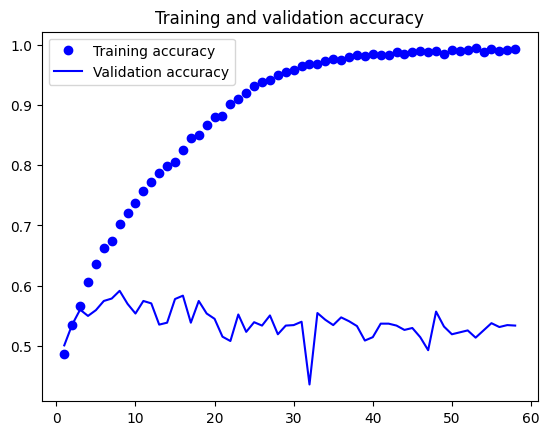

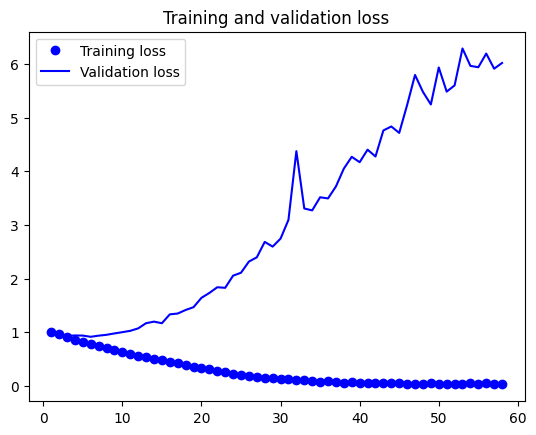


--- Classification Report for model ---
              precision    recall  f1-score   support

      burger     0.3898    0.3938    0.3918       292
      hotdog     0.4371    0.4203    0.4286       364
       pizza     0.6600    0.6723    0.6661       589

    accuracy                         0.5333      1245
   macro avg     0.4957    0.4955    0.4955      1245
weighted avg     0.5315    0.5333    0.5323      1245



<IPython.core.display.Javascript object>

In [ ]:
# Train the model
filter_list = [8, 3, 2]
model, history = define_model(filter_list = filter_list, dataset_train=train_overfit_dataset, dataset_val=test_dataset, callback_loss='accuracy')

# Plot training history
plot(history)

#Do metrics
metrics(model, test_dataset)

#So I know it's done
beep()

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_33 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_33 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 222, 222, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (None, 222, 222, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_107               │ (None, 111, 111, 8)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_108 (Conv2D)             │ (None, 109, 109, 8)    │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (None, 109, 109, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_108               │ (None, 54, 54, 8)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (None, 52, 52, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 52, 52, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_109               │ (None, 26, 26, 8)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_110 (Conv2D)             │ (None, 24, 24, 3)      │           219 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 24, 24, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_110               │ (None, 12, 12, 3)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_111 (Conv2D)             │ (None, 10, 10, 2)      │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 10, 10, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_111               │ (None, 5, 5, 2)        │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_33 (Flatten)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,210 (8.63 KB)

 Trainable params: 2,210 (8.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.4723 - loss: 1.0351 - val_accuracy: 0.5108 - val_loss: 0.9924
Epoch 2/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.5219 - loss: 0.9868 - val_accuracy: 0.5285 - val_loss: 0.9618
Epoch 3/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.5383 - loss: 0.9687 - val_accuracy: 0.5406 - val_loss: 0.9672
Epoch 4/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.5515 - loss: 0.9366 - val_accuracy: 0.5590 - val_loss: 0.9361
Epoch 5/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.5663 - loss: 0.9252 - val_accuracy: 0.5663 - val_loss: 0.9255
Epoch 6/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.5912 - loss: 0.9011 - val_accuracy: 0.5807 - val_loss: 0.9088
Epoch 7/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.5751 - loss: 0.9044 - val_accuracy: 0.5462 - val_loss: 0.9494
Epoch 8/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.5997 - loss: 0.8744 - 

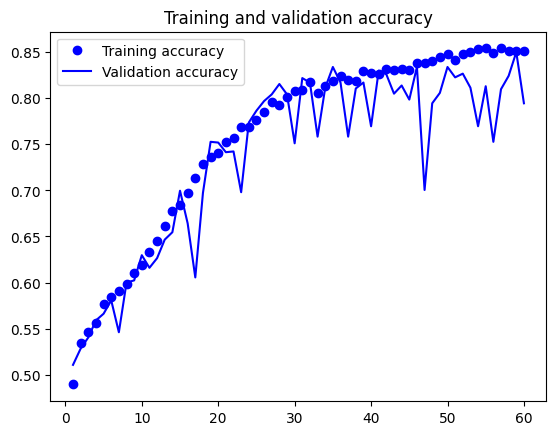

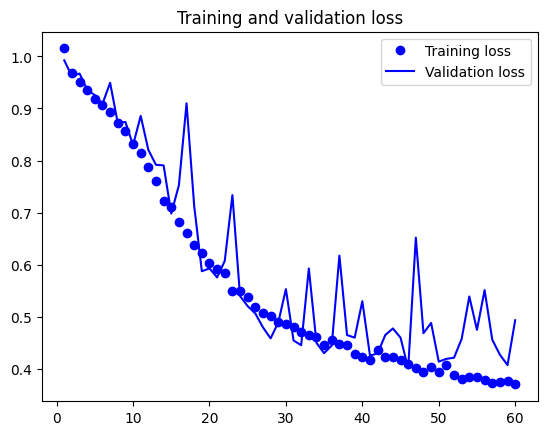


--- Classification Report for model ---
              precision    recall  f1-score   support

      burger     0.5864    0.7671    0.6647       292
      hotdog     0.8539    0.9313    0.8909       364
       pizza     0.9142    0.7233    0.8076       589

    accuracy                         0.7944      1245
   macro avg     0.7848    0.8072    0.7877      1245
weighted avg     0.8197    0.7944    0.7984      1245



<IPython.core.display.Javascript object>

In [ ]:
# Train the model
filter_list = [8, 8, 8, 3, 2]
model, history = define_model(filter_list = filter_list, dataset_train=train_overfit_dataset, dataset_val=test_dataset, callback_loss='accuracy')

# Plot training history
plot(history)

#Do metrics
metrics(model, test_dataset)

#So I know it's done
beep()

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_34 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_34 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_112 (Conv2D)             │ (None, 222, 222, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 222, 222, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_112               │ (None, 111, 111, 8)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_113 (Conv2D)             │ (None, 109, 109, 8)    │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 109, 109, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_113               │ (None, 54, 54, 8)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_114 (Conv2D)             │ (None, 52, 52, 3)      │           219 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_40 (Activation)      │ (None, 52, 52, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_114               │ (None, 26, 26, 3)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ (None, 24, 24, 2)      │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_41 (Activation)      │ (None, 24, 24, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_115               │ (None, 12, 12, 2)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_34 (Flatten)            │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 10)             │         2,890 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,006 (15.65 KB)

 Trainable params: 4,006 (15.65 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.4655 - loss: 1.0647 - val_accuracy: 0.4731 - val_loss: 1.0104
Epoch 2/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.4806 - loss: 0.9898 - val_accuracy: 0.5277 - val_loss: 0.9500
Epoch 3/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5292 - loss: 0.9279 - val_accuracy: 0.5470 - val_loss: 0.9132
Epoch 4/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5882 - loss: 0.8647 - val_accuracy: 0.5799 - val_loss: 0.8709
Epoch 5/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.6326 - loss: 0.8152 - val_accuracy: 0.6161 - val_loss: 0.8527
Epoch 6/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.6470 - loss: 0.8007 - val_accuracy: 0.6129 - val_loss: 0.8462
Epoch 7/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.6646 - loss: 0.7707 - val_accuracy: 0.6329 - val_loss: 0.8231
Epoch 8/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.6780 - loss: 0.7420 - 

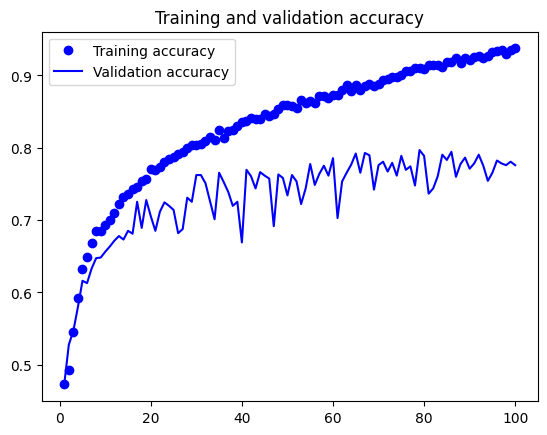

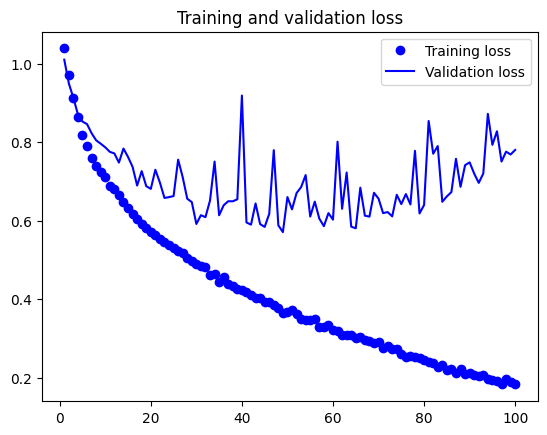


--- Classification Report for model ---
              precision    recall  f1-score   support

      burger     0.6164    0.6712    0.6426       292
      hotdog     0.8011    0.8077    0.8044       364
       pizza     0.8500    0.8081    0.8285       589

    accuracy                         0.7759      1245
   macro avg     0.7558    0.7624    0.7585      1245
weighted avg     0.7809    0.7759    0.7779      1245



<IPython.core.display.Javascript object>

In [ ]:
# Train the model
filter_list = [8, 8, 3, 2]
model, history = define_model(filter_list = filter_list, dataset_train=train_overfit_dataset, dataset_val=test_dataset, callback_loss='accuracy')

# Plot training history
plot(history)

#Do metrics
metrics(model, test_dataset)

#So I know it's done
beep()

# Task 2: Build the Model

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_39 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_39 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_128 (Conv2D)             │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_54 (Activation)      │ (None, 222, 222, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_128               │ (None, 111, 111, 16)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_129 (Conv2D)             │ (None, 109, 109, 6)    │           870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_55 (Activation)      │ (None, 109, 109, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_129               │ (None, 54, 54, 6)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_130 (Conv2D)             │ (None, 52, 52, 4)      │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_56 (Activation)      │ (None, 52, 52, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_130               │ (None, 26, 26, 4)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_39 (Flatten)            │ (None, 2704)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 10)             │        27,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,621 (111.80 KB)

 Trainable params: 28,621 (111.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.4829 - loss: 1.0156 - val_accuracy: 0.5767 - val_loss: 0.9400
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5536 - loss: 0.9456 - val_accuracy: 0.5687 - val_loss: 0.9148
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5744 - loss: 0.9129 - val_accuracy: 0.5938 - val_loss: 0.8966
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6033 - loss: 0.8602 - val_accuracy: 0.5958 - val_loss: 0.8828
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6268 - loss: 0.8393 - val_accuracy: 0.6349 - val_loss: 0.8295
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6535 - loss: 0.7893 - val_accuracy: 0.6449 - val_loss: 0.8200
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6869 - loss: 0.7429 - val_accuracy: 0.6630 - val_loss: 0.7902
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6743 - loss: 0.7364 - 

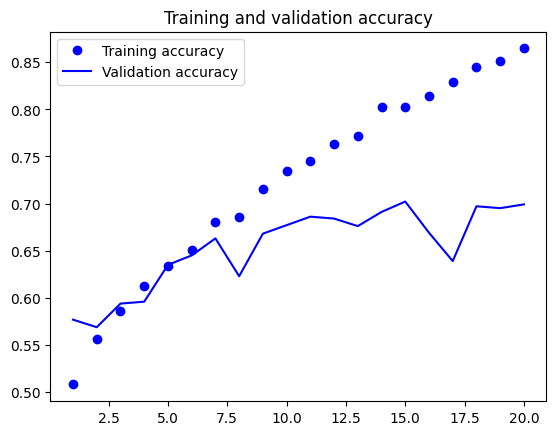

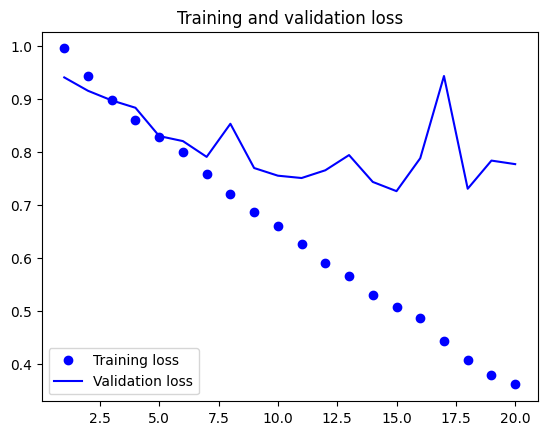


--- Classification Report for model ---
              precision    recall  f1-score   support

      burger     0.5452    0.5582    0.5516       292
      hotdog     0.6982    0.6291    0.6618       364
       pizza     0.7670    0.8048    0.7854       589

    accuracy                         0.6956      1245
   macro avg     0.6701    0.6640    0.6663      1245
weighted avg     0.6948    0.6956    0.6945      1245



<IPython.core.display.Javascript object>

In [ ]:
# Build the Model
# Train the model
filter_list = [16, 6, 4]
model, history = define_model(filter_list = filter_list, dataset_train=train_dataset, dataset_val=validation_dataset, callback_loss='val_loss')

# Plot training history
plot(history)

#Do metrics
metrics(model, test_dataset)

#So I know it's done
beep()

Model: "functional_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_50 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_50 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_172 (Conv2D)             │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_98 (Activation)      │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_173 (Conv2D)             │ (None, 220, 220, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_99 (Activation)      │ (None, 220, 220, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_159               │ (None, 110, 110, 64)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_174 (Conv2D)             │ (None, 108, 108, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_100 (Activation)     │ (None, 108, 108, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_50 (Flatten)            │ (None, 746496)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 10)             │     7,464,970 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,521,323 (28.69 MB)

 Trainable params: 7,521,323 (28.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 195ms/step - accuracy: 0.4508 - loss: 1.6021 - val_accuracy: 0.4865 - val_loss: 1.0735
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 195ms/step - accuracy: 0.4745 - loss: 1.0732 - val_accuracy: 0.4865 - val_loss: 1.0592
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 195ms/step - accuracy: 0.4759 - loss: 1.0632 - val_accuracy: 0.4865 - val_loss: 1.0512
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 195ms/step - accuracy: 0.4708 - loss: 1.0605 - val_accuracy: 0.4865 - val_loss: 1.0468
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 194ms/step - accuracy: 0.4767 - loss: 1.0559 - val_accuracy: 0.4865 - val_loss: 1.0447
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 193ms/step - accuracy: 0.4708 - loss: 1.0573 - val_accuracy: 0.4865 - val_loss: 1.0436
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 193ms/step - accuracy: 0.4486 - loss: 1.0679 - val_accuracy: 0.4865 - val_loss: 1.0429
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 193ms/step - accuracy: 0.4789 -

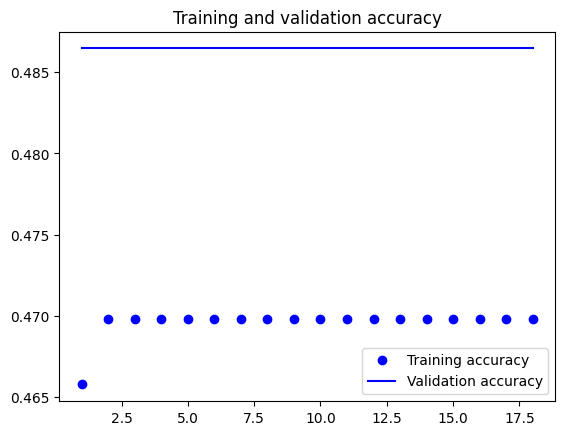

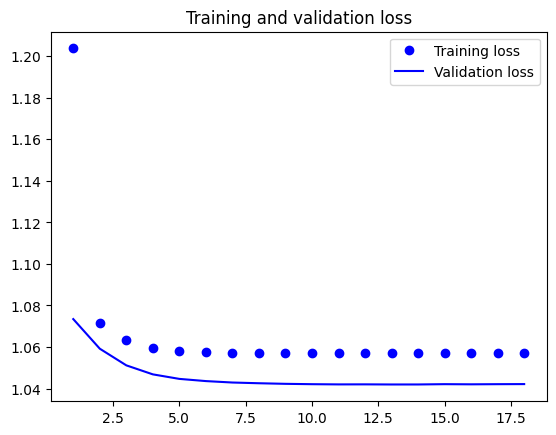


--- Classification Report for model ---
              precision    recall  f1-score   support

      burger     0.0000    0.0000    0.0000       292
      hotdog     0.0000    0.0000    0.0000       364
       pizza     0.4731    1.0000    0.6423       589

    accuracy                         0.4731      1245
   macro avg     0.1577    0.3333    0.2141      1245
weighted avg     0.2238    0.4731    0.3039      1245



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<IPython.core.display.Javascript object>

In [ ]:
# Build the Model
# Train the model
filter_list = [32, 64, 64]
model, history = define_model(filter_list = filter_list, dataset_train=train_dataset, dataset_val=validation_dataset, callback_loss='val_loss', pooling_interval=2)

# Plot training history
plot(history)

#Do metrics
metrics(model, test_dataset)

#So I know it's done
beep()

Model: "functional_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_51 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_51 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_175 (Conv2D)             │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_101 (Activation)     │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_160               │ (None, 111, 111, 32)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_176 (Conv2D)             │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_102 (Activation)     │ (None, 109, 109, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_161               │ (None, 54, 54, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_177 (Conv2D)             │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_103 (Activation)     │ (None, 52, 52, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_162               │ (None, 26, 26, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_51 (Flatten)            │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 10)             │       432,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 489,003 (1.87 MB)

 Trainable params: 489,003 (1.87 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.4350 - loss: 1.0886 - val_accuracy: 0.5186 - val_loss: 0.9790
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.5664 - loss: 0.9295 - val_accuracy: 0.5858 - val_loss: 0.9142
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.6134 - loss: 0.8547 - val_accuracy: 0.4925 - val_loss: 1.0839
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.6540 - loss: 0.8036 - val_accuracy: 0.5928 - val_loss: 1.0189
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.7129 - loss: 0.7008 - val_accuracy: 0.7141 - val_loss: 0.6821
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.7667 - loss: 0.5849 - val_accuracy: 0.7081 - val_loss: 0.7044
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.7944 - loss: 0.5273 - val_accuracy: 0.7202 - val_loss: 0.6832
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.8393 - loss: 0

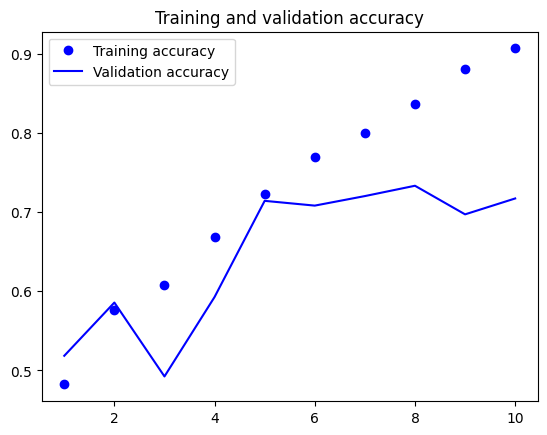

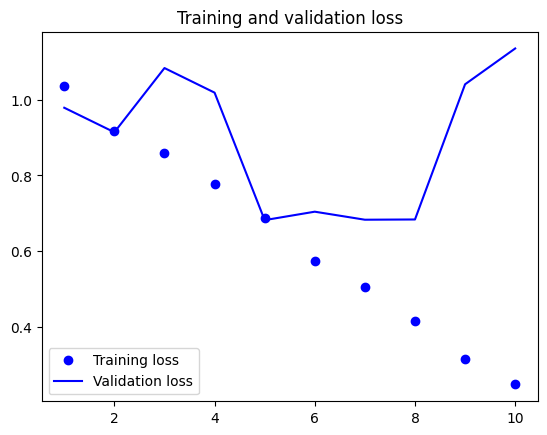


--- Classification Report for model ---
              precision    recall  f1-score   support

      burger     0.7670    0.2705    0.4000       292
      hotdog     0.6758    0.6758    0.6758       364
       pizza     0.6851    0.9049    0.7798       589

    accuracy                         0.6892      1245
   macro avg     0.7093    0.6171    0.6185      1245
weighted avg     0.7016    0.6892    0.6603      1245



<IPython.core.display.Javascript object>

In [ ]:
# Build the Model
# Train the model
filter_list = [32, 64, 64]
model, history = define_model(filter_list = filter_list, dataset_train=train_dataset, dataset_val=validation_dataset, callback_loss='val_loss', pooling_interval=1)

# Plot training history
plot(history)

#Do metrics
metrics(model, test_dataset)

#So I know it's done
beep()

Model: "functional_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_52 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_52 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_178 (Conv2D)             │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_104 (Activation)     │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_163               │ (None, 111, 111, 32)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_179 (Conv2D)             │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_105 (Activation)     │ (None, 109, 109, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_164               │ (None, 54, 54, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_180 (Conv2D)             │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_106 (Activation)     │ (None, 52, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_165               │ (None, 26, 26, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_52 (Flatten)            │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 10)             │       865,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 958,571 (3.66 MB)

 Trainable params: 958,571 (3.66 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - accuracy: 0.4505 - loss: 1.0649 - val_accuracy: 0.5868 - val_loss: 0.9811
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.5458 - loss: 0.9544 - val_accuracy: 0.5827 - val_loss: 0.9217
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - accuracy: 0.6021 - loss: 0.8863 - val_accuracy: 0.6229 - val_loss: 0.8284
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.6202 - loss: 0.8247 - val_accuracy: 0.5807 - val_loss: 0.9069
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.6659 - loss: 0.7690 - val_accuracy: 0.6871 - val_loss: 0.7176
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.7426 - loss: 0.6293 - val_accuracy: 0.6219 - val_loss: 0.8402
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - accuracy: 0.7866 - loss: 0.5304 - val_accuracy: 0.7242 - val_loss: 0.7057
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.8337 - loss: 0

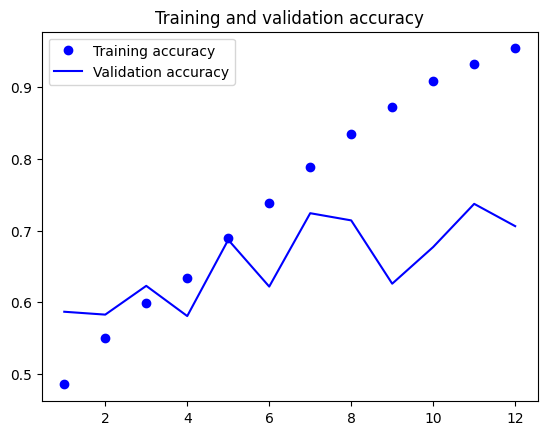

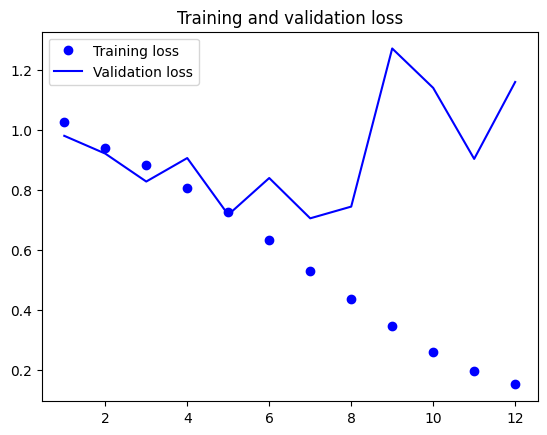


--- Classification Report for model ---
              precision    recall  f1-score   support

      burger     0.6711    0.5171    0.5841       292
      hotdog     0.6858    0.6236    0.6532       364
       pizza     0.7431    0.8693    0.8013       589

    accuracy                         0.7149      1245
   macro avg     0.7000    0.6700    0.6795      1245
weighted avg     0.7095    0.7149    0.7071      1245



<IPython.core.display.Javascript object>

In [ ]:
# Build the Model
# Train the model
filter_list = [32, 64, 128]
model, history = define_model(filter_list = filter_list, dataset_train=train_dataset, dataset_val=validation_dataset, callback_loss='val_loss', pooling_interval=1)

# Plot training history
plot(history)

#Do metrics
metrics(model, test_dataset)

#So I know it's done
beep()

Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_55 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_55 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_189 (Conv2D)             │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_115 (Activation)     │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_174               │ (None, 111, 111, 32)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_190 (Conv2D)             │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_116 (Activation)     │ (None, 109, 109, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_175               │ (None, 54, 54, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_191 (Conv2D)             │ (None, 52, 52, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_117 (Activation)     │ (None, 52, 52, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_176               │ (None, 26, 26, 256)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_192 (Conv2D)             │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_118 (Activation)     │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_177               │ (None, 12, 12, 256)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_55 (Flatten)            │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 10)             │       368,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,125,867 (4.29 MB)

 Trainable params: 1,125,867 (4.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 144ms/step - accuracy: 0.4571 - loss: 1.1230 - val_accuracy: 0.4865 - val_loss: 1.0746
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.4552 - loss: 1.0777 - val_accuracy: 0.4865 - val_loss: 1.0595
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.4725 - loss: 1.0639 - val_accuracy: 0.4865 - val_loss: 1.0514
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.4651 - loss: 1.0629 - val_accuracy: 0.4865 - val_loss: 1.0468
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.4679 - loss: 1.0607 - val_accuracy: 0.4865 - val_loss: 1.0445
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.4705 - loss: 1.0565 - val_accuracy: 0.4865 - val_loss: 1.0435
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.4771 - loss: 1.0518 - val_accuracy: 0.4865 - val_loss: 1.0430
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.4619 -

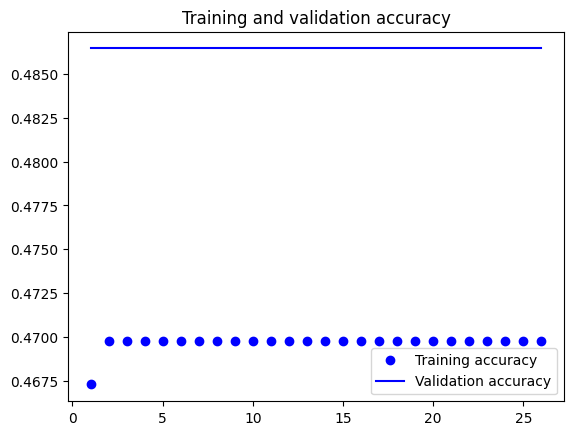

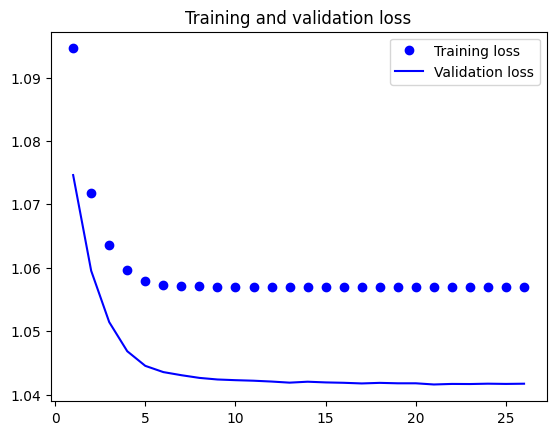


--- Classification Report for model ---
              precision    recall  f1-score   support

      burger     0.0000    0.0000    0.0000       292
      hotdog     0.0000    0.0000    0.0000       364
       pizza     0.4731    1.0000    0.6423       589

    accuracy                         0.4731      1245
   macro avg     0.1577    0.3333    0.2141      1245
weighted avg     0.2238    0.4731    0.3039      1245



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<IPython.core.display.Javascript object>

In [ ]:
# Build the Model
# Train the model
filter_list = [32, 64, 256, 256]
model, history = define_model(filter_list = filter_list, dataset_train=train_dataset, dataset_val=validation_dataset, callback_loss='val_loss', pooling_interval=1)

# Plot training history
plot(history)

#Do metrics
metrics(model, test_dataset)

#So I know it's done
beep()

# Task 3: Data Augmentation

Model: "functional_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_86 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_86 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_width_2 (RandomWidth)    │ (None, 224, None, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_height_2 (RandomHeight)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_301 (Conv2D)             │ (None, None, None, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_226 (Activation)     │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_302 (Conv2D)             │ (None, None, None, 64) │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_227 (Activation)     │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_275               │ (None, None, None, 64) │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_303 (Conv2D)             │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_228 (Activation)     │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_304 (Conv2D)             │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_229 (Activation)     │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_276               │ (None, None, None,     │             0 │
│ (MaxPooling2D)                  │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,155 (945.92 KB)

 Trainable params: 242,155 (945.92 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 432ms/step - accuracy: 0.4747 - loss: 1.0441 - val_accuracy: 0.4955 - val_loss: 0.9890
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 431ms/step - accuracy: 0.5356 - loss: 0.9715 - val_accuracy: 0.5767 - val_loss: 0.9348
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 427ms/step - accuracy: 0.5561 - loss: 0.9421 - val_accuracy: 0.5727 - val_loss: 0.8829
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 426ms/step - accuracy: 0.5791 - loss: 0.9031 - val_accuracy: 0.6158 - val_loss: 0.8644
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 432ms/step - accuracy: 0.5807 - loss: 0.8775 - val_accuracy: 0.6028 - val_loss: 0.8261
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 425ms/step - accuracy: 0.6169 - loss: 0.8244 - val_accuracy: 0.6620 - val_loss: 0.7435
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 428ms/step - accuracy: 0.6541 - loss: 0.7454 - val_accuracy: 0.6861 - val_loss: 0.7577
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 427ms/step - accuracy: 0.6513 -

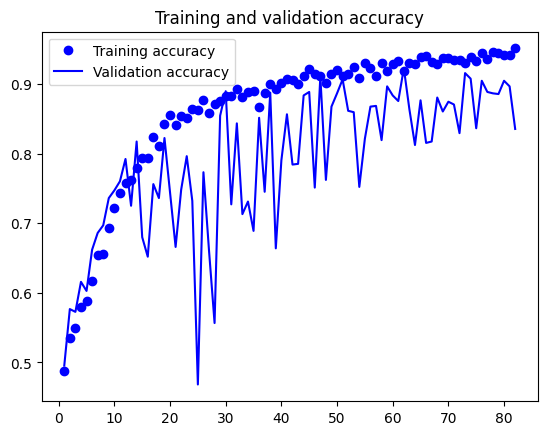

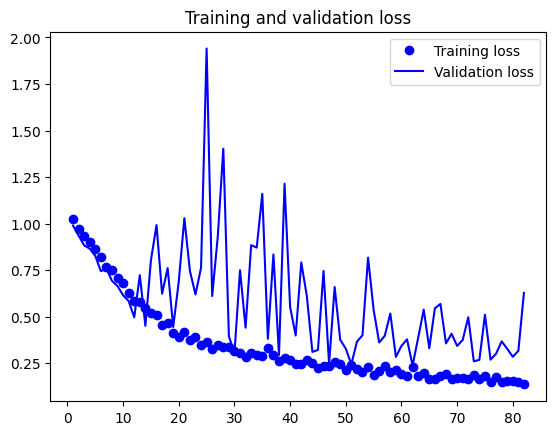


Test Loss: 0.8778
Test Accuracy: 0.7912

--- Classification Report ---
              precision    recall  f1-score   support

      burger     0.8485    0.4795    0.6127       292
      hotdog     0.6367    0.9918    0.7755       364
       pizza     0.9435    0.8217    0.8784       589

    accuracy                         0.7912      1245
   macro avg     0.8095    0.7643    0.7555      1245
weighted avg     0.8315    0.7912    0.7860      1245



<IPython.core.display.Javascript object>

In [145]:
filter_list = [32, 64, 128, 128]
model, history = define_model(filter_list = filter_list, dataset_train=train_dataset, dataset_val=validation_dataset,
                              augmentation=1, callback_loss='val_loss', pooling_interval=2, patience=20)

# Plot training history
plot(history)

#Do metrics
metrics(model, test_dataset)

#So I know it's done
beep()

Model: "functional_85"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_87 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_87 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_width_3 (RandomWidth)    │ (None, 224, None, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_height_3 (RandomHeight)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_305 (Conv2D)             │ (None, None, None, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_230 (Activation)     │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_277               │ (None, None, None, 32) │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_306 (Conv2D)             │ (None, None, None, 64) │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_231 (Activation)     │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_278               │ (None, None, None, 64) │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_307 (Conv2D)             │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_232 (Activation)     │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_279               │ (None, None, None,     │             0 │
│ (MaxPooling2D)                  │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_308 (Conv2D)             │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_233 (Activation)     │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_280               │ (None, None, None,     │             0 │
│ (MaxPooling2D)                  │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_14     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_147 (Dense)               │ (None, 10)             │         1,29

 Total params: 242,155 (945.92 KB)

 Trainable params: 242,155 (945.92 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.4654 - loss: 1.0651 - val_accuracy: 0.5226 - val_loss: 0.9607
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.5320 - loss: 0.9679 - val_accuracy: 0.6028 - val_loss: 0.8959
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - accuracy: 0.5542 - loss: 0.9268 - val_accuracy: 0.5747 - val_loss: 0.8931
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.5695 - loss: 0.9149 - val_accuracy: 0.6158 - val_loss: 0.8453
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.6108 - loss: 0.8463 - val_accuracy: 0.6239 - val_loss: 0.8061
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.6264 - loss: 0.8168 - val_accuracy: 0.6299 - val_loss: 0.8276
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - accuracy: 0.6584 - loss: 0.7573 - val_accuracy: 0.6379 - val_loss: 0.7778
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.6872 -

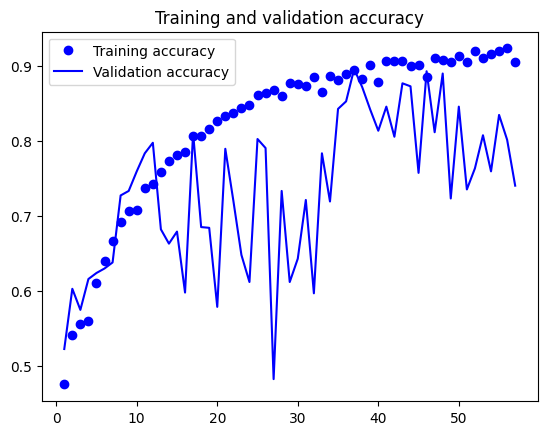

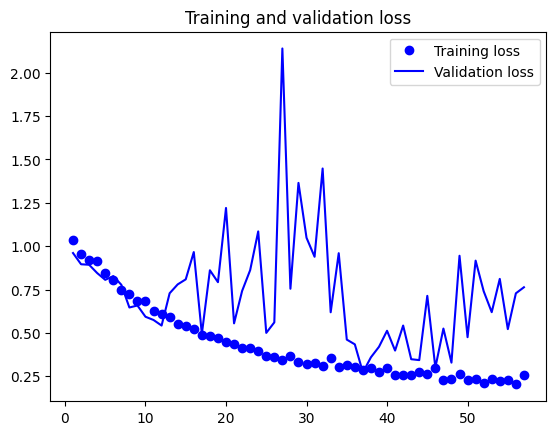


Test Loss: 0.9616
Test Accuracy: 0.6787

--- Classification Report ---
              precision    recall  f1-score   support

      burger     0.8358    0.3836    0.5258       292
      hotdog     0.4965    0.9863    0.6605       364
       pizza     0.9639    0.6350    0.7656       589

    accuracy                         0.6787      1245
   macro avg     0.7654    0.6683    0.6507      1245
weighted avg     0.7972    0.6787    0.6786      1245



<IPython.core.display.Javascript object>

In [146]:
filter_list = [32, 64, 128, 128]
model, history = define_model(filter_list = filter_list, dataset_train=train_dataset, dataset_val=validation_dataset, augmentation=2, callback_loss='val_loss', patience=20)

# Plot training history
plot(history)

#Do metrics
metrics(model, test_dataset)

#So I know it's done
beep()

Model: "functional_86"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_88 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_88 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_width_4 (RandomWidth)    │ (None, 224, None, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_height_4 (RandomHeight)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, None, None, 3)  │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_309 (Conv2D)             │ (None, None, None, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_234 (Activation)     │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_281               │ (None, None, None, 32) │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_310 (Conv2D)             │ (None, None, None, 64) │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_235 (Activation)     │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_282               │ (None, None, None, 64) │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_311 (Conv2D)             │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_236 (Activation)     │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_283               │ (None, None, None,     │             0 │
│ (MaxPooling2D)                  │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_312 (Conv2D)             │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_237 (Activation)     │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_284               │ (None, None, None,     │             0 │
│ (MaxPooling2D)                  │ 128)                   │             

 Total params: 242,155 (945.92 KB)

 Trainable params: 242,155 (945.92 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.4710 - loss: 1.0432 - val_accuracy: 0.5807 - val_loss: 0.9700
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.5087 - loss: 0.9893 - val_accuracy: 0.5797 - val_loss: 0.9122
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.5868 - loss: 0.9080 - val_accuracy: 0.5777 - val_loss: 0.9466
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.5883 - loss: 0.8835 - val_accuracy: 0.6169 - val_loss: 0.8149
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.6328 - loss: 0.8058 - val_accuracy: 0.6028 - val_loss: 0.8250
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - accuracy: 0.6671 - loss: 0.7586 - val_accuracy: 0.6941 - val_loss: 0.6970
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.7062 - loss: 0.6980 - val_accuracy: 0.7101 - val_loss: 0.6837
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.6885 -

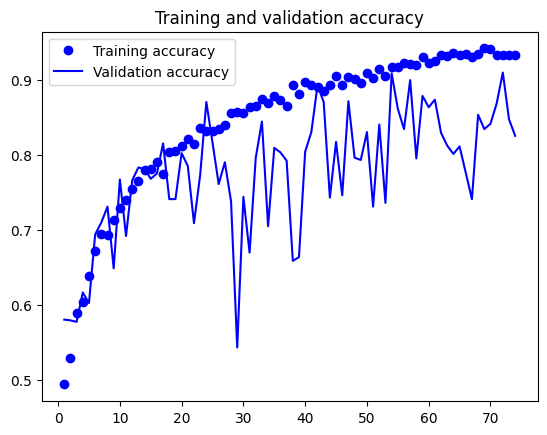

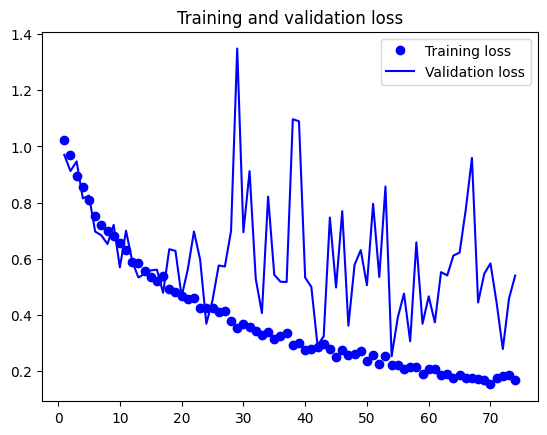


Test Loss: 0.6571
Test Accuracy: 0.7928

--- Classification Report ---
              precision    recall  f1-score   support

      burger     0.8705    0.5753    0.6928       292
      hotdog     0.6272    0.9890    0.7676       364
       pizza     0.9603    0.7793    0.8604       589

    accuracy                         0.7928      1245
   macro avg     0.8193    0.7812    0.7736      1245
weighted avg     0.8418    0.7928    0.7939      1245



<IPython.core.display.Javascript object>

In [147]:
# Training data generator with augmentat

filter_list = [32, 64, 128, 128]
model, history = define_model(filter_list = filter_list, dataset_train=train_dataset, augmentation=3, dataset_val=validation_dataset, callback_loss='val_loss', patience=20)

# Plot training history
plot(history)

#Do metrics
metrics(model, test_dataset)

#So I know it's done
beep()

# Regularization

In [ ]:
filter_list = [32, 64, 128, 128]
model, history = define_model(
    filter_list = filter_list,
    dataset_train=train_dataset,
    dataset_val=validation_dataset,
    callback_loss='val_loss',
    batch=True,
    augmentation=3,
    patience=20
    )

# Plot training history
plot(history)

#Do metrics
metrics(model, test_dataset)

#So I know it's done
beep()

Model: "functional_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_90 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_90 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_2 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_width_5 (RandomWidth)    │ (None, 224, None, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_height_5 (RandomHeight)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_1               │ (None, None, None, 3)  │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_317 (Conv2D)             │ (None, None, None, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_242 (Activation)     │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_289               │ (None, None, None, 32) │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_318 (Conv2D)             │ (None, None, None, 64) │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_243 (Activation)     │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_290               │ (None, None, None, 64) │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_319 (Conv2D)             │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_244 (Activation)     │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_291               │ (None, None, None,     │             0 │
│ (MaxPooling2D)                  │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_320 (Conv2D)             │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_245 (Activation)     │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_292               │ (None, None, None,     │             0 │
│ (MaxPooling2D)                  │ 128)                   │             

 Total params: 242,155 (945.92 KB)

 Trainable params: 242,155 (945.92 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.4360 - loss: 1.0735 - val_accuracy: 0.4865 - val_loss: 0.9970
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.4656 - loss: 1.0336 - val_accuracy: 0.4865 - val_loss: 0.9590
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.4647 - loss: 1.0340 - val_accuracy: 0.4865 - val_loss: 0.9942
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.4833 - loss: 0.9997 - val_accuracy: 0.5436 - val_loss: 0.9101
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.5257 - loss: 0.9616 - val_accuracy: 0.5075 - val_loss: 0.9121
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.5230 - loss: 0.9757 - val_accuracy: 0.6108 - val_loss: 0.8665
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.5187 - loss: 0.9788 - val_accuracy: 0.5948 - val_loss: 0.8823
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.5292 -

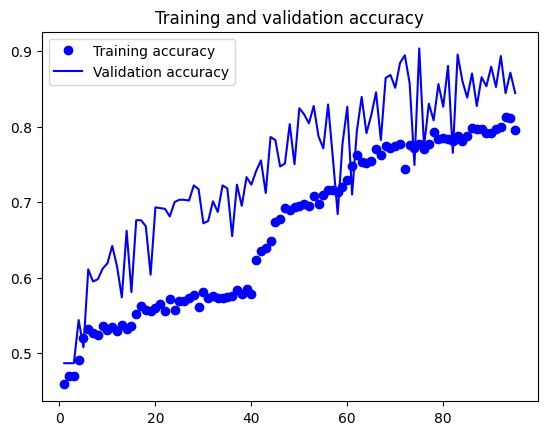

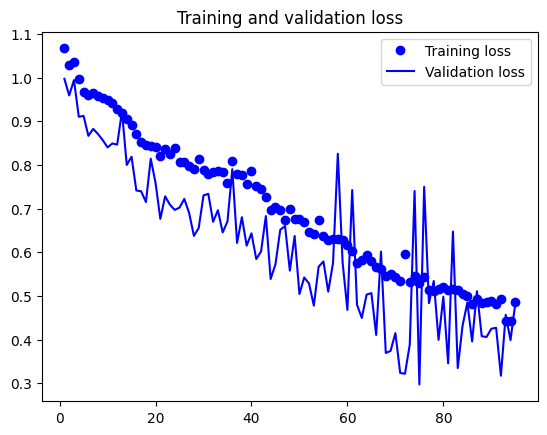


Test Loss: 0.5754
Test Accuracy: 0.8137

--- Classification Report ---
              precision    recall  f1-score   support

      burger     0.7500    0.7295    0.7396       292
      hotdog     0.7050    0.9780    0.8193       364
       pizza     0.9737    0.7538    0.8498       589

    accuracy                         0.8137      1245
   macro avg     0.8095    0.8204    0.8029      1245
weighted avg     0.8427    0.8137    0.8150      1245



<IPython.core.display.Javascript object>

In [149]:
filter_list = [32, 64, 128, 128]
model, history = define_model(
    filter_list = filter_list,
    dataset_train=train_dataset,
    dataset_val=validation_dataset,
    callback_loss='val_loss',
    batch=False,
    augmentation=3,
    patience=20,
    dropout=True)


# Plot training history
plot(history)

#Do metrics
metrics(model, test_dataset)

#So I know it's done
beep()

Model: "functional_89"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_91 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_91 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_3 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_3               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_width_6 (RandomWidth)    │ (None, 224, None, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_height_6 (RandomHeight)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_2 (RandomZoom)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_2               │ (None, None, None, 3)  │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_321 (Conv2D)             │ (None, None, None, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_246 (Activation)     │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_293               │ (None, None, None, 32) │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_322 (Conv2D)             │ (None, None, None, 64) │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_247 (Activation)     │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_294               │ (None, None, None, 64) │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_323 (Conv2D)             │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_248 (Activation)     │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_295               │ (None, None, None,     │             0 │
│ (MaxPooling2D)                  │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_324 (Conv2D)             │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_249 (Activation)     │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_296               │ (None, None, None,     │             0 │
│ (MaxPooling2D)                  │ 128)                   │             

 Total params: 242,155 (945.92 KB)

 Trainable params: 242,155 (945.92 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.4522 - loss: 2.1974 - val_accuracy: 0.4865 - val_loss: 1.0854
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - accuracy: 0.4751 - loss: 1.0849 - val_accuracy: 0.4865 - val_loss: 1.0646
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - accuracy: 0.4533 - loss: 1.0790 - val_accuracy: 0.4865 - val_loss: 1.0525
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.4614 - loss: 1.0712 - val_accuracy: 0.4865 - val_loss: 1.0506
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.4806 - loss: 1.0559 - val_accuracy: 0.4865 - val_loss: 1.0595
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - accuracy: 0.4670 - loss: 1.0661 - val_accuracy: 0.4865 - val_loss: 1.0487
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.4690 - loss: 1.0637 - val_accuracy: 0.4865 - val_loss: 1.0489
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.4791 -

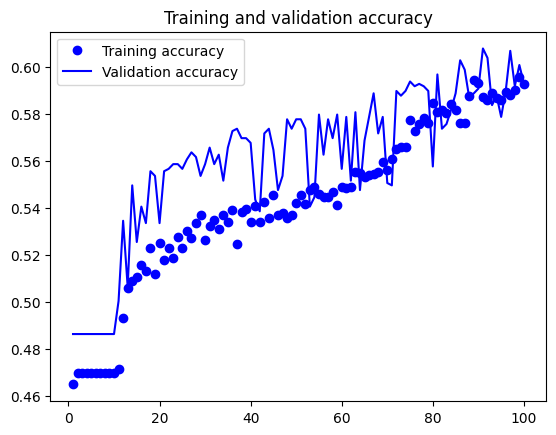

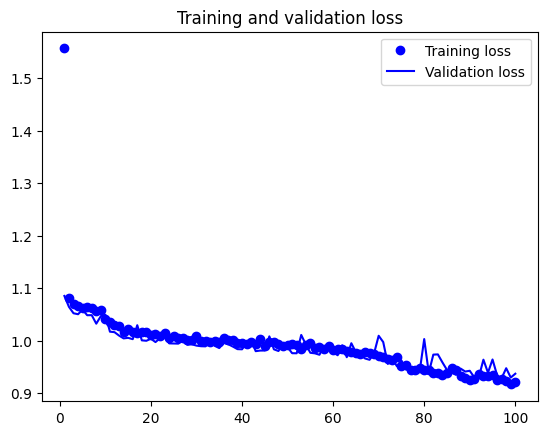


Test Loss: 0.9541
Test Accuracy: 0.5783

--- Classification Report ---
              precision    recall  f1-score   support

      burger     0.0000    0.0000    0.0000       292
      hotdog     0.5048    0.5824    0.5408       364
       pizza     0.6158    0.8625    0.7185       589

    accuracy                         0.5783      1245
   macro avg     0.3735    0.4816    0.4198      1245
weighted avg     0.4389    0.5783    0.4980      1245



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<IPython.core.display.Javascript object>

In [150]:
filter_list = [32, 64, 128, 128]
model, history = define_model(
    filter_list = filter_list,
    dataset_train=train_dataset,
    dataset_val=validation_dataset,
    callback_loss='val_loss',
    augmentation=3,
    batch=False,
    dropout=False,
    patience=20,
    l2=True)


# Plot training history
plot(history)

#Do metrics
metrics(model, test_dataset)

#So I know it's done
beep()

Model: "functional_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_92 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_92 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_4 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_4               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_width_7 (RandomWidth)    │ (None, 224, None, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_height_7 (RandomHeight)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_3 (RandomZoom)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_3               │ (None, None, None, 3)  │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_325 (Conv2D)             │ (None, None, None, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, None, None, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_250 (Activation)     │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_297               │ (None, None, None, 32) │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_326 (Conv2D)             │ (None, None, None, 64) │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, None, None, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_251 (Activation)     │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_298               │ (None, None, None, 64) │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_327 (Conv2D)             │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, None, None,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_252 (Activation)     │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_299               │ (None, None, None,     │             0 │
│ (MaxPooling2D)                  │ 128)                   │             

 Total params: 243,563 (951.42 KB)

 Trainable params: 242,859 (948.67 KB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 258ms/step - accuracy: 0.5095 - loss: 3.1786 - val_accuracy: 0.3109 - val_loss: 1.9100
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 259ms/step - accuracy: 0.5499 - loss: 1.4500 - val_accuracy: 0.3109 - val_loss: 2.0046
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 258ms/step - accuracy: 0.5662 - loss: 1.1577 - val_accuracy: 0.3139 - val_loss: 1.5996
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 259ms/step - accuracy: 0.5946 - loss: 1.0175 - val_accuracy: 0.6118 - val_loss: 1.0012
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 260ms/step - accuracy: 0.6187 - loss: 0.9815 - val_accuracy: 0.5627 - val_loss: 1.1191
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 257ms/step - accuracy: 0.6356 - loss: 0.9343 - val_accuracy: 0.5838 - val_loss: 0.9565
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 257ms/step - accuracy: 0.6304 - loss: 0.9592 - val_accuracy: 0.7071 - val_loss: 0.9092
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 258ms/step - accuracy: 0.6344 -

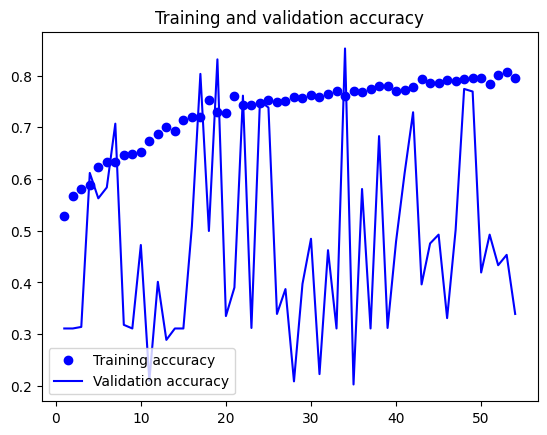

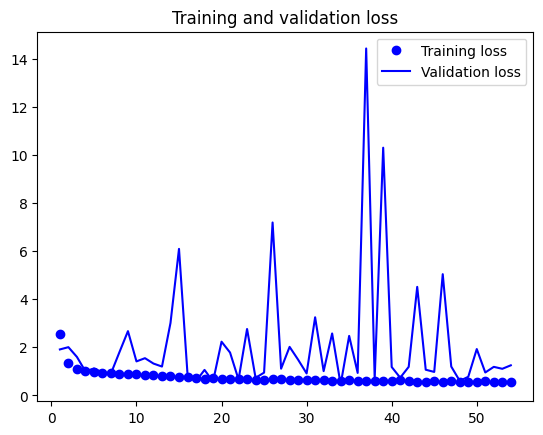


Test Loss: 1.2154
Test Accuracy: 0.3574

--- Classification Report ---
              precision    recall  f1-score   support

      burger     0.2676    1.0000    0.4223       292
      hotdog     0.9928    0.3791    0.5487       364
       pizza     1.0000    0.0255    0.0497       589

    accuracy                         0.3574      1245
   macro avg     0.7535    0.4682    0.3402      1245
weighted avg     0.8261    0.3574    0.2830      1245



<IPython.core.display.Javascript object>

In [151]:
filter_list = [32, 64, 128, 128]
model, history = define_model(
    filter_list = filter_list,
    dataset_train=train_dataset,
    dataset_val=validation_dataset,
    callback_loss='val_loss',
    augmentation=3,
    batch=True,
    patience=20,
    dropout=True,
    l2=True)


# Plot training history
plot(history)

#Do metrics
metrics(model, test_dataset)

#So I know it's done
beep()

# Tasks 6: Use pre-trained models and recent architectures

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_91"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_93      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_93[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,027 (91.98 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 279ms/step - accuracy: 0.7712 - loss: 0.7971 - val_accuracy: 0.9348 - val_loss: 0.1856
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 276ms/step - accuracy: 0.9343 - loss: 0.1976 - val_accuracy: 0.9498 - val_loss: 0.1312
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 267ms/step - accuracy: 0.9584 - loss: 0.1324 - val_accuracy: 0.9679 - val_loss: 0.1009
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 262ms/step - accuracy: 0.9686 - loss: 0.0916 - val_accuracy: 0.9438 - val_loss: 0.1409
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 263ms/step - accuracy: 0.9675 - loss: 0.0855 - val_accuracy: 0.9609 - val_loss: 0.1077
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 263ms/step - accuracy: 0.9695 - loss: 0.0851 - val_accuracy: 0.9599 - val_loss: 0.1097
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 262ms/step - accuracy: 0.9770 - loss: 0.0773 - val_accuracy: 0.9599 - val_loss: 0.1032
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 264ms/step - accuracy: 0.9824 -

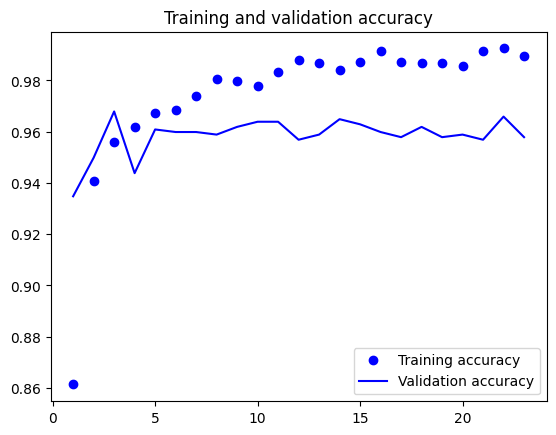

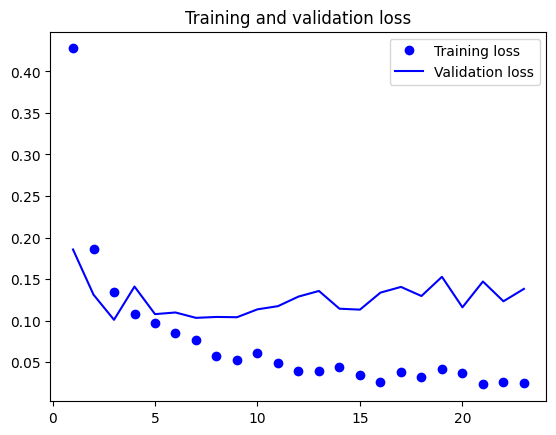


Test Loss: 0.2247
Test Accuracy: 0.9566

--- Classification Report ---
              precision    recall  f1-score   support

      burger     0.9278    0.9247    0.9262       292
      hotdog     0.9537    0.9615    0.9576       364
       pizza     0.9727    0.9694    0.9711       589

    accuracy                         0.9566      1245
   macro avg     0.9514    0.9519    0.9516      1245
weighted avg     0.9566    0.9566    0.9566      1245



<IPython.core.display.Javascript object>

In [152]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable=False
inputs = base_model.input
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='hotdog_convnet.keras',
        save_best_only=True,
        monitor='val_loss'),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        verbose=1)
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

# Plot training history
plot(history)

#Do metrics
metrics(model, test_dataset)

#So I know it's done
beep()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_92"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_94 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_21     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_161 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,787 (56.64 MB)

 Trainable params: 132,099 (516.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 564ms/step - accuracy: 0.6905 - loss: 2.4544 - val_accuracy: 0.8656 - val_loss: 0.4460
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 561ms/step - accuracy: 0.8552 - loss: 0.4189 - val_accuracy: 0.8957 - val_loss: 0.3272
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 72s 560ms/step - accuracy: 0.8900 - loss: 0.2979 - val_accuracy: 0.8917 - val_loss: 0.3119
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 559ms/step - accuracy: 0.8954 - loss: 0.2718 - val_accuracy: 0.9087 - val_loss: 0.2997
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 558ms/step - accuracy: 0.9203 - loss: 0.2018 - val_accuracy: 0.9067 - val_loss: 0.2879
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 72s 557ms/step - accuracy: 0.9381 - loss: 0.1710 - val_accuracy: 0.9097 - val_loss: 0.3108
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 72s 559ms/step - accuracy: 0.9387 - loss: 0.1626 - val_accuracy: 0.9208 - val_loss: 0.3084
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 72s 560ms/step - accuracy: 0.9492 -

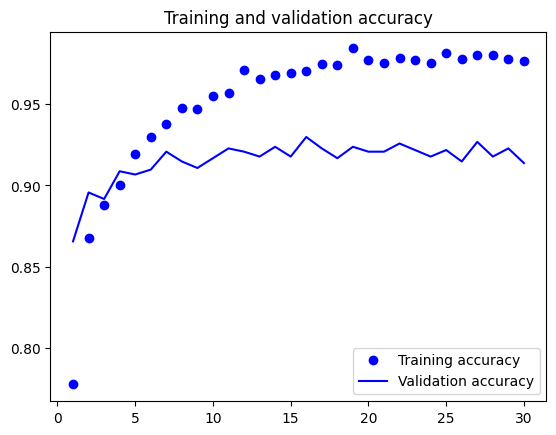

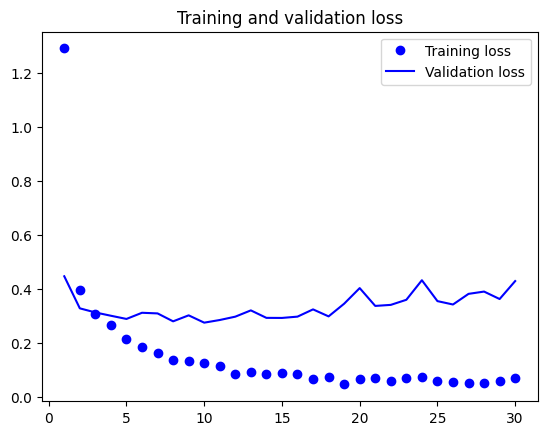


Test Loss: 0.4736
Test Accuracy: 0.9108

--- Classification Report ---
              precision    recall  f1-score   support

      burger     0.9213    0.8014    0.8571       292
      hotdog     0.9003    0.8929    0.8966       364
       pizza     0.9127    0.9762    0.9434       589

    accuracy                         0.9108      1245
   macro avg     0.9114    0.8902    0.8990      1245
weighted avg     0.9111    0.9108    0.9095      1245



<IPython.core.display.Javascript object>

In [153]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable=False
inputs = base_model.input
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='hotdog_convnet.keras',
        save_best_only=True,
        monitor='val_loss'),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        verbose=1)
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

# Plot training history
plot(history)

#Do metrics
metrics(model, test_dataset)

#So I know it's done
beep()

In [154]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, preprocess = clip.load('ViT-B/32', device=device)
dataset = datasets.ImageFolder(root=train_path, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

100%|███████████████████████████████████████| 338M/338M [00:13<00:00, 25.5MiB/s]


In [155]:
labels = ['photo of hotdog', 'photo of hamburger', 'photo of pizza']
text_inputs = clip.tokenize(labels).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_inputs)

In [156]:
y_true = []
y_pred = []

for images, targets in dataloader:
    images = images.to(device)

    with torch.no_grad():
        image_features = model.encode_image(images)
        logits = image_features @ text_features.T
        probs = logits.softmax(dim=-1).cpu().numpy()

    for i, prob in enumerate(probs):
        pred_idx = prob.argmax()
        y_pred.append(pred_idx)
        y_true.append(targets[i].item())  # Convert tensor to int

class_names = dataset.classes
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

      burger       0.01      0.01      0.01      1169
      hotdog       0.07      0.06      0.06      1458
       pizza       0.96      1.00      0.98      2359

    accuracy                           0.49      4986
   macro avg       0.35      0.35      0.35      4986
weighted avg       0.48      0.49      0.48      4986

